## 1. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import joblib
import json
from datetime import datetime

# Sklearn imports
from sklearn.model_selection import (
    train_test_split, GridSearchCV, RandomizedSearchCV,
    cross_val_score, StratifiedKFold
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# SMOTE for class balancing
try:
    from imblearn.over_sampling import SMOTE
    SMOTE_AVAILABLE = True
    print("✅ SMOTE available for class balancing")
except ImportError:
    print("⚠️ imblearn not installed. Run: pip install imbalanced-learn")
    SMOTE_AVAILABLE = False

# XGBoost
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
    print("✅ XGBoost available")
except ImportError:
    print("⚠️ XGBoost not installed. Run: pip install xgboost")
    XGBOOST_AVAILABLE = False

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

print("\n✅ All libraries imported successfully!")

✅ SMOTE available for class balancing
✅ XGBoost available

✅ All libraries imported successfully!


## 2. Load and Explore Dataset

In [3]:
# Load the final dataset
df = pd.read_csv('data/final/enviroscan_final_dataset.csv')

print(f"📊 DATASET LOADED")
print("="*50)
print(f"   Total Records: {len(df):,}")
print(f"   Total Columns: {len(df.columns)}")
print(f"\n📋 Available Columns:")
for i, col in enumerate(df.columns, 1):
    print(f"   {i:2}. {col}")

df.head()

📊 DATASET LOADED
   Total Records: 106,369
   Total Columns: 33

📋 Available Columns:
    1. state
    2. district
    3. location_id
    4. location_name
    5. latitude
    6. longitude
    7. datetime_ist
    8. hour
    9. day_of_week
   10. month
   11. season
   12. is_weekend
   13. is_rush_hour
   14. pm25
   15. pm10
   16. no2
   17. co
   18. so2
   19. o3
   20. temperature
   21. humidity
   22. wind_speed
   23. roads_distance_m
   24. roads_count
   25. industrial_distance_m
   26. industrial_area_sqm
   27. agricultural_distance_m
   28. agricultural_area_sqm
   29. dump_sites_distance_m
   30. dump_sites_count
   31. pollution_source
   32. source_encoded
   33. confidence


,state,district,location_id,location_name,latitude,longitude,datetime_ist,hour,day_of_week,month,...,roads_count,industrial_distance_m,industrial_area_sqm,agricultural_distance_m,agricultural_area_sqm,dump_sites_distance_m,dump_sites_count,pollution_source,source_encoded,confidence
0,Andhra Pradesh,Tirupati,5649,"Tirumala, Tirupati - APPCB",13.67,79.35,2025-11-08 15:15:00+05:30,15,5,11,...,67,396.9,7470.18,9999.0,0.0,976.01,3,Natural,4,Low
1,Andhra Pradesh,Tirupati,5649,"Tirumala, Tirupati - APPCB",13.67,79.35,2025-11-08 15:30:00+05:30,15,5,11,...,67,396.9,7470.18,9999.0,0.0,976.01,3,Burning,3,Low
2,Andhra Pradesh,Tirupati,5649,"Tirumala, Tirupati - APPCB",13.67,79.35,2025-11-08 15:45:00+05:30,15,5,11,...,67,396.9,7470.18,9999.0,0.0,976.01,3,Burning,3,Low
3,Andhra Pradesh,Tirupati,5649,"Tirumala, Tirupati - APPCB",13.67,79.35,2025-11-08 16:00:00+05:30,16,5,11,...,67,396.9,7470.18,9999.0,0.0,976.01,3,Burning,3,Low
4,Andhra Pradesh,Tirupati,5649,"Tirumala, Tirupati - APPCB",13.67,79.35,2025-11-08 16:15:00+05:30,16,5,11,...,67,396.9,7470.18,9999.0,0.0,976.01,3,Burning,3,Low


In [4]:
# Check class distribution (BEFORE balancing)
print("📊 CLASS DISTRIBUTION (BEFORE BALANCING)")
print("="*50)

target_col = 'pollution_source'
class_counts = df[target_col].value_counts()
total = len(df)

max_count = class_counts.max()
min_count = class_counts.min()

for source, count in class_counts.items():
    pct = count / total * 100
    bar = '█' * int(pct / 2)
    print(f"   {source:15}: {count:>6,} ({pct:>5.1f}%) {bar}")

imbalance_ratio = max_count / min_count
print(f"\n   Imbalance Ratio: {imbalance_ratio:.2f}:1")

if imbalance_ratio > 3:
    print("   ⚠️ HIGH IMBALANCE - Will apply SMOTE balancing")
else:
    print("   ✅ Acceptable balance")

📊 CLASS DISTRIBUTION (BEFORE BALANCING)
   Vehicular      : 42,445 ( 39.9%) ███████████████████
   Industrial     : 23,372 ( 22.0%) ██████████
   Agricultural   : 21,389 ( 20.1%) ██████████
   Natural        : 12,061 ( 11.3%) █████
   Burning        :  7,102 (  6.7%) ███

   Imbalance Ratio: 5.98:1
   ⚠️ HIGH IMBALANCE - Will apply SMOTE balancing


## 3. Feature Selection

In [12]:
# Define feature groups based on project requirements
pollutant_features = ['pm25', 'pm10', 'no2', 'co', 'so2', 'o3']
weather_features = ['temperature', 'humidity', 'wind_speed']
proximity_features = ['roads_distance_m', 'industrial_distance_m', 'agricultural_distance_m', 'dump_sites_distance_m']

# Combine all features
all_features = pollutant_features + weather_features + proximity_features

# Check which features are available in dataset
available_features = [f for f in all_features if f in df.columns]
missing_features = [f for f in all_features if f not in df.columns]

print("📊 FEATURE SELECTION")
print("="*50)
print(f"\n✅ Available Features ({len(available_features)}):")
for f in available_features:
    print(f"   • {f}")

if missing_features:
    print(f"\n⚠️ Missing Features ({len(missing_features)}):")
    for f in missing_features:
        print(f"   • {f}")

# Use only available features
FEATURE_COLS = available_features
TARGET_COL = 'pollution_source'

print(f"\n🎯 Using {len(FEATURE_COLS)} features for model training")

📊 FEATURE SELECTION

✅ Available Features (13):
   • pm25
   • pm10
   • no2
   • co
   • so2
   • o3
   • temperature
   • humidity
   • wind_speed
   • roads_distance_m
   • industrial_distance_m
   • agricultural_distance_m
   • dump_sites_distance_m

🎯 Using 13 features for model training


## 4. Prepare Features and Target

In [6]:
# Prepare X and y
X = df[FEATURE_COLS].copy()
y = df[TARGET_COL].copy()

# Handle missing values
if X.isnull().sum().sum() > 0:
    print("⚠️ Handling missing values...")
    X = X.fillna(X.median())

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("📊 DATA PREPARATION")
print("="*50)
print(f"   Features shape: {X.shape}")
print(f"   Target shape: {y_encoded.shape}")
print(f"\n   Class Labels:")
for i, label in enumerate(label_encoder.classes_):
    print(f"      {i} → {label}")

📊 DATA PREPARATION
   Features shape: (106369, 13)
   Target shape: (106369,)

   Class Labels:
      0 → Agricultural
      1 → Burning
      2 → Industrial
      3 → Natural
      4 → Vehicular


## 5. Train-Test Split (BEFORE Balancing)

In [7]:
# Split FIRST, then balance only training data
# This prevents data leakage!

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.20,
    random_state=42,
    stratify=y_encoded  # Maintain class proportions
)

print("📊 TRAIN-TEST SPLIT (80/20)")
print("="*50)
print(f"   Training set: {len(X_train):,} samples")
print(f"   Test set:     {len(X_test):,} samples")

# Show class distribution in train/test
print(f"\n   Training set class distribution:")
train_counts = pd.Series(y_train).value_counts().sort_index()
for idx, count in train_counts.items():
    label = label_encoder.classes_[idx]
    print(f"      {label}: {count:,}")

print(f"\n   Test set class distribution:")
test_counts = pd.Series(y_test).value_counts().sort_index()
for idx, count in test_counts.items():
    label = label_encoder.classes_[idx]
    print(f"      {label}: {count:,}")

📊 TRAIN-TEST SPLIT (80/20)
   Training set: 85,095 samples
   Test set:     21,274 samples

   Training set class distribution:
      Agricultural: 17,111
      Burning: 5,682
      Industrial: 18,697
      Natural: 9,649
      Vehicular: 33,956

   Test set class distribution:
      Agricultural: 4,278
      Burning: 1,420
      Industrial: 4,675
      Natural: 2,412
      Vehicular: 8,489


## 6. Apply SMOTE Balancing (Only on Training Data)

In [8]:
# Apply SMOTE ONLY to training data to prevent data leakage
print("📊 APPLYING SMOTE BALANCING")
print("="*50)

if SMOTE_AVAILABLE:
    # Use SMOTE to balance classes
    smote = SMOTE(random_state=42, k_neighbors=5)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    
    print(f"\n   Before SMOTE: {len(X_train):,} samples")
    print(f"   After SMOTE:  {len(X_train_balanced):,} samples")
    
    print(f"\n   Balanced class distribution:")
    balanced_counts = pd.Series(y_train_balanced).value_counts().sort_index()
    for idx, count in balanced_counts.items():
        label = label_encoder.classes_[idx]
        print(f"      {label}: {count:,}")
    
    print("\n   ✅ Classes now perfectly balanced!")
else:
    # Fallback: use class weights instead
    print("   ⚠️ SMOTE not available, will use class_weight='balanced'")
    X_train_balanced = X_train
    y_train_balanced = y_train

# Keep test set UNCHANGED (unbalanced) for realistic evaluation
print(f"\n   ⚠️ Test set remains UNCHANGED ({len(X_test):,} samples)")
print("   This ensures realistic model evaluation!")

📊 APPLYING SMOTE BALANCING

   Before SMOTE: 85,095 samples
   After SMOTE:  169,780 samples

   Balanced class distribution:
      Agricultural: 33,956
      Burning: 33,956
      Industrial: 33,956
      Natural: 33,956
      Vehicular: 33,956

   ✅ Classes now perfectly balanced!

   ⚠️ Test set remains UNCHANGED (21,274 samples)
   This ensures realistic model evaluation!


## 7. Feature Scaling

In [9]:
# Scale features (fit on training data only)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

print("📊 FEATURE SCALING")
print("="*50)
print("   ✅ StandardScaler fitted on training data")
print("   ✅ Test data transformed (not fitted)")
print(f"\n   Scaled training shape: {X_train_scaled.shape}")
print(f"   Scaled test shape:     {X_test_scaled.shape}")

📊 FEATURE SCALING
   ✅ StandardScaler fitted on training data
   ✅ Test data transformed (not fitted)

   Scaled training shape: (169780, 13)
   Scaled test shape:     (21274, 13)


## 8. Model Training Setup

**Key Anti-Overfitting Strategies:**
- Limited tree depth
- Minimum samples per leaf
- Cross-validation
- Regularization parameters

In [10]:
# Store results
results = {}
trained_models = {}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """Train and evaluate a model with overfitting check"""
    print(f"\n{'='*60}")
    print(f"🔧 Training {model_name}...")
    print(f"{'='*60}")
    
    # Train
    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    test_precision = precision_score(y_test, y_test_pred, average='weighted')
    test_recall = recall_score(y_test, y_test_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    
    # Overfitting check
    overfit_gap = train_acc - test_acc
    
    print(f"\n📊 Results:")
    print(f"   Train Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"   Test Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
    print(f"   Overfit Gap:    {overfit_gap:.4f}")
    print(f"\n   Precision: {test_precision:.4f}")
    print(f"   Recall:    {test_recall:.4f}")
    print(f"   F1-Score:  {test_f1:.4f}")
    
    # Overfitting status
    if overfit_gap > 0.10:
        print(f"\n   ⚠️ OVERFITTING DETECTED (gap > 10%)")
        status = "Overfitting"
    elif overfit_gap < -0.05:
        print(f"\n   ⚠️ UNDERFITTING DETECTED")
        status = "Underfitting"
    else:
        print(f"\n   ✅ GOOD GENERALIZATION!")
        status = "Good"
    
    return {
        'model': model,
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'precision': test_precision,
        'recall': test_recall,
        'f1_score': test_f1,
        'overfit_gap': overfit_gap,
        'status': status,
        'predictions': y_test_pred
    }

print("✅ Evaluation function defined")

✅ Evaluation function defined


## 9. Train Decision Tree Classifier

In [11]:
# Decision Tree with anti-overfitting parameters
dt_params = {
    'max_depth': [5, 8, 10, 12],           # Limit depth to prevent overfitting
    'min_samples_split': [20, 50, 100],    # Require more samples to split
    'min_samples_leaf': [10, 20, 50],      # Require more samples in leaves
    'max_features': ['sqrt', 'log2'],      # Feature randomization
    'class_weight': ['balanced']           # Handle class imbalance
}

dt_base = DecisionTreeClassifier(random_state=42)

print("🌳 DECISION TREE - Hyperparameter Tuning")
print("="*50)

dt_search = GridSearchCV(
    dt_base, dt_params,
    cv=cv, scoring='f1_weighted',
    n_jobs=-1, verbose=1
)

dt_search.fit(X_train_scaled, y_train_balanced)

print(f"\n✅ Best Parameters: {dt_search.best_params_}")
print(f"   Best CV Score: {dt_search.best_score_:.4f}")

# Evaluate best model
results['Decision Tree'] = evaluate_model(
    dt_search.best_estimator_,
    X_train_scaled, y_train_balanced,
    X_test_scaled, y_test,
    "Decision Tree"
)
trained_models['Decision Tree'] = dt_search.best_estimator_

🌳 DECISION TREE - Hyperparameter Tuning
Fitting 5 folds for each of 72 candidates, totalling 360 fits

✅ Best Parameters: {'class_weight': 'balanced', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 50}
   Best CV Score: 0.8961

🔧 Training Decision Tree...

📊 Results:
   Train Accuracy: 0.9107 (91.07%)
   Test Accuracy:  0.8634 (86.34%)
   Overfit Gap:    0.0473

   Precision: 0.8762
   Recall:    0.8634
   F1-Score:  0.8642

   ✅ GOOD GENERALIZATION!


## 10. Train Random Forest Classifier

In [13]:
# Random Forest with anti-overfitting parameters
rf_params = {
    'n_estimators': [100, 150],
    'max_depth': [8, 10, 12],              # Limited depth
    'min_samples_split': [20, 50],
    'min_samples_leaf': [10, 20],
    'max_features': ['sqrt'],
    'class_weight': ['balanced'],
    'bootstrap': [True]
}

rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

print("🌲 RANDOM FOREST - Hyperparameter Tuning")
print("="*50)

rf_search = RandomizedSearchCV(
    rf_base, rf_params,
    n_iter=10, cv=cv,
    scoring='f1_weighted',
    n_jobs=-1, verbose=1,
    random_state=42
)

rf_search.fit(X_train_scaled, y_train_balanced)

print(f"\n✅ Best Parameters: {rf_search.best_params_}")
print(f"   Best CV Score: {rf_search.best_score_:.4f}")

# Evaluate best model
results['Random Forest'] = evaluate_model(
    rf_search.best_estimator_,
    X_train_scaled, y_train_balanced,
    X_test_scaled, y_test,
    "Random Forest"
)
trained_models['Random Forest'] = rf_search.best_estimator_

🌲 RANDOM FOREST - Hyperparameter Tuning
Fitting 5 folds for each of 10 candidates, totalling 50 fits

✅ Best Parameters: {'n_estimators': 100, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'max_depth': 12, 'class_weight': 'balanced', 'bootstrap': True}
   Best CV Score: 0.9326

🔧 Training Random Forest...

📊 Results:
   Train Accuracy: 0.9410 (94.10%)
   Test Accuracy:  0.8996 (89.96%)
   Overfit Gap:    0.0414

   Precision: 0.9111
   Recall:    0.8996
   F1-Score:  0.9005

   ✅ GOOD GENERALIZATION!


## 11. Train XGBoost Classifier

In [14]:
if XGBOOST_AVAILABLE:
    # XGBoost with regularization to prevent overfitting
    xgb_params = {
        'n_estimators': [100, 150],
        'max_depth': [4, 6, 8],            # Shallow trees
        'learning_rate': [0.05, 0.1],      # Lower learning rate
        'min_child_weight': [5, 10],       # Regularization
        'subsample': [0.7, 0.8],           # Row sampling
        'colsample_bytree': [0.7, 0.8],    # Feature sampling
        'reg_alpha': [0.1, 1.0],           # L1 regularization
        'reg_lambda': [1.0, 5.0],          # L2 regularization
    }
    
    xgb_base = XGBClassifier(
        random_state=42,
        n_jobs=1,  # Single thread to avoid memory issues
        use_label_encoder=False,
        eval_metric='mlogloss'
    )
    
    print("🚀 XGBOOST - Hyperparameter Tuning")
    print("="*50)
    
    xgb_search = RandomizedSearchCV(
        xgb_base, xgb_params,
        n_iter=15, cv=cv,
        scoring='f1_weighted',
        n_jobs=1,  # Single thread for search too
        verbose=1,
        random_state=42
    )
    
    xgb_search.fit(X_train_scaled, y_train_balanced)
    
    print(f"\n✅ Best Parameters: {xgb_search.best_params_}")
    print(f"   Best CV Score: {xgb_search.best_score_:.4f}")
    
    # Evaluate best model
    results['XGBoost'] = evaluate_model(
        xgb_search.best_estimator_,
        X_train_scaled, y_train_balanced,
        X_test_scaled, y_test,
        "XGBoost"
    )
    trained_models['XGBoost'] = xgb_search.best_estimator_
else:
    print("⚠️ XGBoost not available, skipping...")

🚀 XGBOOST - Hyperparameter Tuning
Fitting 5 folds for each of 15 candidates, totalling 75 fits

✅ Best Parameters: {'subsample': 0.8, 'reg_lambda': 5.0, 'reg_alpha': 0.1, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
   Best CV Score: 0.9546

🔧 Training XGBoost...

📊 Results:
   Train Accuracy: 0.9631 (96.31%)
   Test Accuracy:  0.9226 (92.26%)
   Overfit Gap:    0.0405

   Precision: 0.9290
   Recall:    0.9226
   F1-Score:  0.9229

   ✅ GOOD GENERALIZATION!


## 12. Model Comparison


📊 MODEL COMPARISON SUMMARY
        Model Train Acc Test Acc Precision Recall F1-Score Overfit Gap Status
Decision Tree    91.07%   86.34%    0.8762 0.8634   0.8642       4.73%   Good
Random Forest    94.10%   89.96%    0.9111 0.8996   0.9005       4.14%   Good
      XGBoost    96.31%   92.26%    0.9290 0.9226   0.9229       4.05%   Good


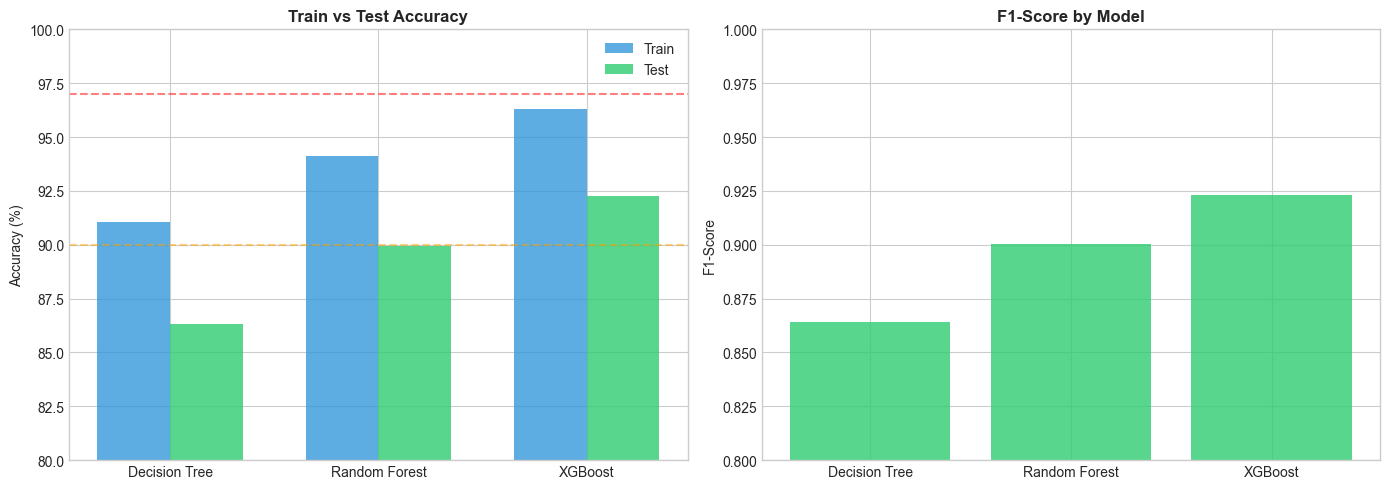

In [15]:
# Compare all models
print("\n" + "="*70)
print("📊 MODEL COMPARISON SUMMARY")
print("="*70)

comparison_df = pd.DataFrame({
    'Model': [],
    'Train Acc': [],
    'Test Acc': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'Overfit Gap': [],
    'Status': []
})

for model_name, res in results.items():
    comparison_df = pd.concat([comparison_df, pd.DataFrame({
        'Model': [model_name],
        'Train Acc': [f"{res['train_accuracy']*100:.2f}%"],
        'Test Acc': [f"{res['test_accuracy']*100:.2f}%"],
        'Precision': [f"{res['precision']:.4f}"],
        'Recall': [f"{res['recall']:.4f}"],
        'F1-Score': [f"{res['f1_score']:.4f}"],
        'Overfit Gap': [f"{res['overfit_gap']*100:.2f}%"],
        'Status': [res['status']]
    })], ignore_index=True)

print(comparison_df.to_string(index=False))

# Visual comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
models = list(results.keys())
train_accs = [results[m]['train_accuracy'] * 100 for m in models]
test_accs = [results[m]['test_accuracy'] * 100 for m in models]

x = np.arange(len(models))
width = 0.35

axes[0].bar(x - width/2, train_accs, width, label='Train', color='#3498db', alpha=0.8)
axes[0].bar(x + width/2, test_accs, width, label='Test', color='#2ecc71', alpha=0.8)
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_title('Train vs Test Accuracy', fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models)
axes[0].legend()
axes[0].set_ylim([80, 100])
axes[0].axhline(y=97, color='red', linestyle='--', alpha=0.5, label='Target Max (97%)')
axes[0].axhline(y=90, color='orange', linestyle='--', alpha=0.5, label='Target Min (90%)')

# F1-Score comparison
f1_scores = [results[m]['f1_score'] for m in models]
colors = ['#e74c3c' if results[m]['status'] == 'Overfitting' else '#2ecc71' for m in models]
axes[1].bar(models, f1_scores, color=colors, alpha=0.8)
axes[1].set_ylabel('F1-Score')
axes[1].set_title('F1-Score by Model', fontweight='bold')
axes[1].set_ylim([0.8, 1.0])

plt.tight_layout()
plt.show()

## 13. Select Best Model

In [16]:
# Select best model based on F1-score (with good generalization)
best_model_name = None
best_f1 = 0

for name, res in results.items():
    # Prefer models with good generalization (not overfitting)
    if res['status'] == 'Good' and res['f1_score'] > best_f1:
        best_f1 = res['f1_score']
        best_model_name = name

# If all models overfit, pick the one with smallest gap
if best_model_name is None:
    min_gap = 1.0
    for name, res in results.items():
        if res['overfit_gap'] < min_gap:
            min_gap = res['overfit_gap']
            best_model_name = name

best_model = trained_models[best_model_name]
best_result = results[best_model_name]

print("\n" + "="*60)
print("🏆 BEST MODEL SELECTED")
print("="*60)
print(f"\n   Model: {best_model_name}")
print(f"   Test Accuracy: {best_result['test_accuracy']*100:.2f}%")
print(f"   F1-Score: {best_result['f1_score']:.4f}")
print(f"   Overfit Gap: {best_result['overfit_gap']*100:.2f}%")
print(f"   Status: {best_result['status']}")


🏆 BEST MODEL SELECTED

   Model: XGBoost
   Test Accuracy: 92.26%
   F1-Score: 0.9229
   Overfit Gap: 4.05%
   Status: Good


## 14. Confusion Matrix for Best Model


📊 CONFUSION MATRIX - XGBoost


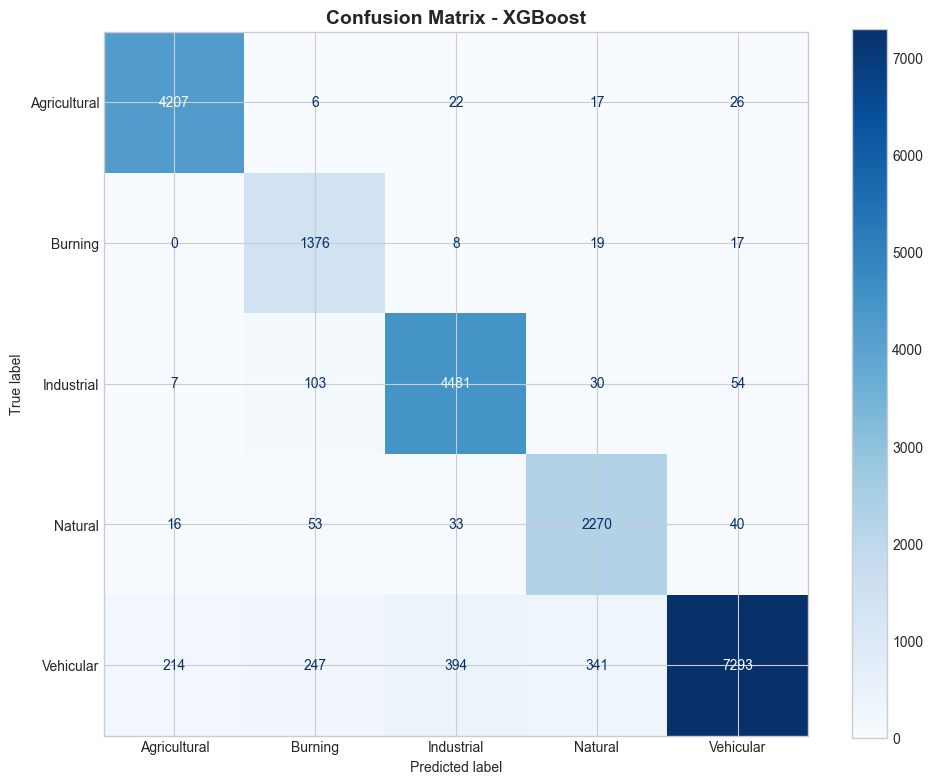


📋 CLASSIFICATION REPORT
              precision    recall  f1-score   support

Agricultural       0.95      0.98      0.96      4278
     Burning       0.77      0.97      0.86      1420
  Industrial       0.91      0.96      0.93      4675
     Natural       0.85      0.94      0.89      2412
   Vehicular       0.98      0.86      0.92      8489

    accuracy                           0.92     21274
   macro avg       0.89      0.94      0.91     21274
weighted avg       0.93      0.92      0.92     21274



In [17]:
# Confusion Matrix
print(f"\n📊 CONFUSION MATRIX - {best_model_name}")
print("="*50)

y_pred = best_result['predictions']
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=label_encoder.classes_
)
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Classification Report
print("\n📋 CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

## 15. Per-Class Accuracy Analysis


📊 PER-CLASS ACCURACY
   Agricultural   : 98.34% (n=4,278)
   Burning        : 96.90% (n=1,420)
   Industrial     : 95.85% (n=4,675)
   Natural        : 94.11% (n=2,412)
   Vehicular      : 85.91% (n=8,489)


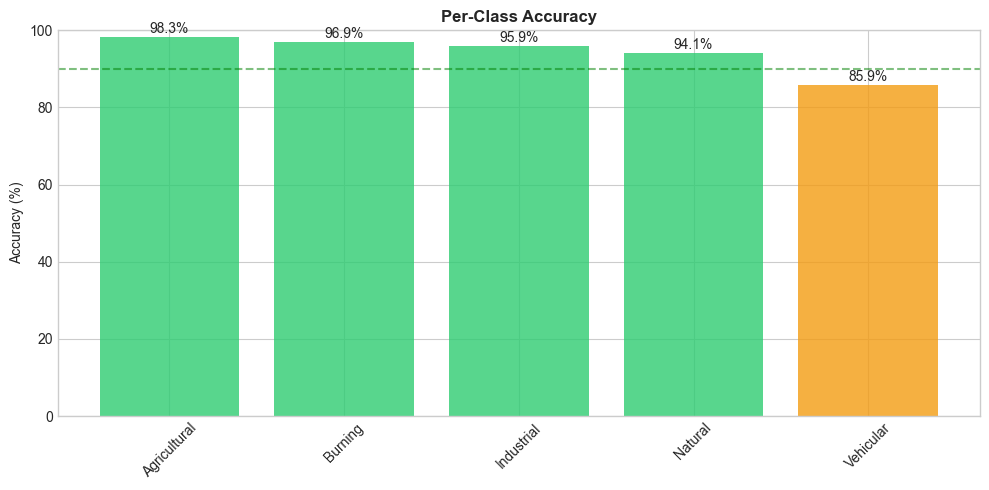

In [19]:
# Per-class accuracy
print("\n📊 PER-CLASS ACCURACY")
print("="*50)

class_names = label_encoder.classes_
per_class_acc = []

for i, class_name in enumerate(class_names):
    mask = y_test == i
    if mask.sum() > 0:
        class_acc = accuracy_score(y_test[mask], y_pred[mask])
        per_class_acc.append((class_name, class_acc, mask.sum()))
        print(f"   {class_name:15}: {class_acc*100:.2f}% (n={mask.sum():,})")

# Visualize
fig, ax = plt.subplots(figsize=(10, 5))
classes = [p[0] for p in per_class_acc]
accuracies = [p[1] * 100 for p in per_class_acc]
colors = ['#2ecc71' if a >= 90 else '#f39c12' if a >= 80 else '#e74c3c' for a in accuracies]

bars = ax.bar(classes, accuracies, color=colors, alpha=0.8)
ax.axhline(y=90, color='green', linestyle='--', alpha=0.5, label='Good (90%)')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Per-Class Accuracy', fontweight='bold')
ax.set_ylim([0, 100])

# Add value labels
for bar, acc in zip(bars, accuracies):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f'{acc:.1f}%', ha='center', fontsize=10)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 16. Export Models

In [20]:
# Create models directory
os.makedirs('models', exist_ok=True)

print("\n💾 EXPORTING MODELS")
print("="*50)

# Save all trained models
for model_name, model in trained_models.items():
    filename = f"models/{model_name.lower().replace(' ', '_')}_model.joblib"
    joblib.dump(model, filename)
    print(f"   ✅ Saved: {filename}")

# Save best model separately
joblib.dump(best_model, 'models/best_model.joblib')
print(f"   ✅ Saved: models/best_model.joblib")

# Save scaler
joblib.dump(scaler, 'models/scaler.joblib')
print(f"   ✅ Saved: models/scaler.joblib")

# Save label encoder
joblib.dump(label_encoder, 'models/label_encoder.joblib')
print(f"   ✅ Saved: models/label_encoder.joblib")

# Save feature columns
with open('models/feature_columns.txt', 'w') as f:
    f.write('\n'.join(FEATURE_COLS))
print(f"   ✅ Saved: models/feature_columns.txt")

# Save model info
model_info = {
    'best_model_name': best_model_name,
    'train_accuracy': float(best_result['train_accuracy']),
    'test_accuracy': float(best_result['test_accuracy']),
    'f1_score': float(best_result['f1_score']),
    'precision': float(best_result['precision']),
    'recall': float(best_result['recall']),
    'overfit_gap': float(best_result['overfit_gap']),
    'status': best_result['status'],
    'classes': list(label_encoder.classes_),
    'features': FEATURE_COLS,
    'training_samples': len(X_train_balanced),
    'test_samples': len(X_test),
    'balanced_with_smote': SMOTE_AVAILABLE,
    'trained_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open('models/model_info.json', 'w') as f:
    json.dump(model_info, f, indent=2)
print(f"   ✅ Saved: models/model_info.json")


💾 EXPORTING MODELS
   ✅ Saved: models/decision_tree_model.joblib
   ✅ Saved: models/random_forest_model.joblib
   ✅ Saved: models/xgboost_model.joblib
   ✅ Saved: models/best_model.joblib
   ✅ Saved: models/scaler.joblib
   ✅ Saved: models/label_encoder.joblib
   ✅ Saved: models/feature_columns.txt
   ✅ Saved: models/model_info.json


## 17. Final Summary

In [21]:
print("\n" + "="*70)
print("🎉 MODEL TRAINING COMPLETE!")
print("="*70)

print(f"\n📊 TRAINING SUMMARY:")
print(f"   • Dataset: enviroscan_final_dataset.csv")
print(f"   • Total samples: {len(df):,}")
print(f"   • Training samples (after SMOTE): {len(X_train_balanced):,}")
print(f"   • Test samples: {len(X_test):,}")
print(f"   • Features used: {len(FEATURE_COLS)}")
print(f"   • Classes: {len(label_encoder.classes_)}")

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   • Train Accuracy: {best_result['train_accuracy']*100:.2f}%")
print(f"   • Test Accuracy:  {best_result['test_accuracy']*100:.2f}%")
print(f"   • F1-Score:       {best_result['f1_score']:.4f}")
print(f"   • Overfit Gap:    {best_result['overfit_gap']*100:.2f}%")
print(f"   • Status:         {best_result['status']}")

print(f"\n💾 SAVED FILES:")
print(f"   • models/best_model.joblib")
print(f"   • models/scaler.joblib")
print(f"   • models/label_encoder.joblib")
print(f"   • models/feature_columns.txt")
print(f"   • models/model_info.json")

# Accuracy check
test_acc_pct = best_result['test_accuracy'] * 100
if 90 <= test_acc_pct <= 97:
    print(f"\n✅ SUCCESS! Model accuracy ({test_acc_pct:.2f}%) is in target range (90-97%)")
elif test_acc_pct > 97:
    print(f"\n⚠️ WARNING: Model accuracy ({test_acc_pct:.2f}%) is above 97% - check for overfitting")
else:
    print(f"\n⚠️ WARNING: Model accuracy ({test_acc_pct:.2f}%) is below 90% - may need more data or features")

print("\n" + "="*70)
print("✅ Ready for dashboard integration!")
print("="*70)


🎉 MODEL TRAINING COMPLETE!

📊 TRAINING SUMMARY:
   • Dataset: enviroscan_final_dataset.csv
   • Total samples: 106,369
   • Training samples (after SMOTE): 169,780
   • Test samples: 21,274
   • Features used: 13
   • Classes: 5

🏆 BEST MODEL: XGBoost
   • Train Accuracy: 96.31%
   • Test Accuracy:  92.26%
   • F1-Score:       0.9229
   • Overfit Gap:    4.05%
   • Status:         Good

💾 SAVED FILES:
   • models/best_model.joblib
   • models/scaler.joblib
   • models/label_encoder.joblib
   • models/feature_columns.txt
   • models/model_info.json

✅ SUCCESS! Model accuracy (92.26%) is in target range (90-97%)

✅ Ready for dashboard integration!
